<a href="https://colab.research.google.com/github/Anaya666/Anaya666/blob/main/class08_NN1_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks I: Introduction & Multi-Layer Perceptrons (MLPs)

This is your first session on **Neural Networks**, one of the foundational techniques in machine learning and the core building block of **Deep Learning**.

In this lesson, we will focus on a specific type of neural network called the **Multi-Layer Perceptron (MLP)**. MLPs are also referred to simply as *feedforward neural networks*. While conceptually straightforward, they are powerful models capable of learning complex patterns by combining multiple layers of simple computational units (neurons).

By the end of this lesson, you should be able to:

- Understand the motivation behind Multi-Layer Perceptrons.
- Recognize how a Multi-Layer Perceptron generalizes **Logistic Regression** for non-linear classification.
- Identify and compare common **activation functions** used in neural networks.
- Implement a simple **single-hidden-layer perceptron** using `PyTorch` for binary classification tasks.

## 1. Motivation

### From Linear Regression to Binary Classification

As you now, in a linear regression model model the predictions are given by:

$$\hat{y} = \sum_{j=1}^{m}x_{ij} w_j + b\;,$$
where {$w_j,b$} are the slopes and intercept parameters that are learned by minimizing the Mean Squared Error (MSE) cost function:

$$\sum_{i=1}^N\left(y_i - \sum_{j=1}^{m}x_{ij} w_j - b\right)^2$$

We also covered its implementation in `PyTorch`, optimizing (minimizing) the model using a **Stochastic Gradient Descent** approach.

---

**Reminder**: Gradient descent is a general method for numerically minimizing functions by moving down in the direction opposite to the gradients (tangent to the function's curve). In machine learning, this is used to minimize a cost function, $J(\theta)$, with respect to the model parameters, $\theta$. Along the way, these parameters are updated as follows:

$$\theta \leftarrow \theta - \gamma \, \frac{\partial J}{\partial \theta}, $$
where $\gamma$ is the learning rate, which determines how much of the gradient of $J$ is used to update the parameters in each iteration.

The term stochastic refers here to the fact that each update is based on a single randomly selected data point, rather than the entire dataset.

Using one single point at a time can be computationally expensive and be more susceptible to overfitting, especially if we have noisy data. Later in this module, we will cover more robust alternatives.

In [9]:
import numpy as np
import matplotlib.pylab as plt
import torch
#define class
class LinearRegressionSGD(object):
#define constructor
    def __init__(self, num_features, learning_rate=0.01): #initialises model parameters
        self.w = torch.randn(num_features, 1, dtype=torch.float32, requires_grad=True) #weights initialised randomly with shape, requires_grad = True tells python to track operations for automatic differentiation
        self.b = torch.randn(1, dtype=torch.float32, requires_grad=True) #bias term with gradients enabled
        self.lr = learning_rate #controls how big a step we take when updating weights

    def forward(self, x): #computes the models prediction: Xw+ b
        return x @ self.w + self.b
        #x @ self.w performs matrix multiplication and adds bias b to every prediction- returns the predicted output tensor.

    def loss(self, y_pred, y_true): #computes mean squared error- measures how far predictions are from true value.
        return torch.mean((y_pred - y_true) ** 2)

    def fit(self, X, y, epochs=100): #input data a tensor since we use pytorch
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

        for epoch in range(epochs): #training loop. Repeats training for set number of epochs= iterations of the dataset

            preds = self.forward(X) #predicting output for current weights and biases
            cost = self.loss(preds, y) #calculates MSE between predictions and actual values

            cost.backward() #uses automatic differentiation to calculate gradients w.r to self.w and self.b

            with torch.no_grad(): #disables gradient tracking so we can manually update parameters.
                self.w -= self.lr*self.w.grad
                self.b -= self.lr*self.b.grad
                #in each part we use a new gradient
                #clears stored gradients- needed before the next iteration
                self.w.grad.zero_()
                self.b.grad.zero_()

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Cost: {cost.item():.4f}") #every 10 epochs, print the cost to monitor training process.

                # CODE COMES HERE (set grads of w and b zero (call zero_()))

    def predict(self, X): #converts X to tensor and runs the forward pass to get predictions.
        X = torch.tensor(X, dtype=torch.float32)
        return self.forward(X).detach().numpy()


        #1. initialised weights and biases
        #2. use pytorch tensors for computation
        #3. train using gradient descent
        #4. print loss periodically
        #5. predict new outputs using learned parameters.

In [10]:

# Generate some dummy datanp.random.seed(0)
X = np.random.rand(100, 1)
y = 3 * X[:, 0] + 2 + 0.1 * np.random.randn(100)

# Fit the model
model = LinearRegressionSGD(num_features =1, learning_rate=0.1)
model.fit(X, y, epochs=200)


# Predict on new data
y_pred = model.predict(X)

# Check learned parameters
print("Estimated weight:", model.w.item())
print("Estimated bias:", model.b.item())

Epoch 0, Cost: 6.3386
Epoch 10, Cost: 0.1581
Epoch 20, Cost: 0.1115
Epoch 30, Cost: 0.0874
Epoch 40, Cost: 0.0690
Epoch 50, Cost: 0.0550
Epoch 60, Cost: 0.0443
Epoch 70, Cost: 0.0361
Epoch 80, Cost: 0.0298
Epoch 90, Cost: 0.0251
Epoch 100, Cost: 0.0214
Epoch 110, Cost: 0.0186
Epoch 120, Cost: 0.0165
Epoch 130, Cost: 0.0149
Epoch 140, Cost: 0.0136
Epoch 150, Cost: 0.0127
Epoch 160, Cost: 0.0119
Epoch 170, Cost: 0.0114
Epoch 180, Cost: 0.0110
Epoch 190, Cost: 0.0106
Estimated weight: 2.9256720542907715
Estimated bias: 2.039931535720825


In this case, our prediction is a continuous value, which makes sense given that we are performing a regression task.

### From a continuous output into a classifying rule

What if we want to binarize our observations based on their continuos output?

We saw an example of this in the **Perceptron**, which assigned labels to the observations based on the following:

$$
\hat{y} = \sigma(z) =
\begin{cases}
1 & \text{if z} > 0 \\
0 & \text{otherwise}
\end{cases}
$$
where $\sigma(z)$ is a decision function --here taking the unit step-- based on typical linear transformation from the input $z=\sum_{j=1}^m x_{ij}w_j + b$.

As you can see, this decision function has turned our regression model into a **binary classifier**.

This mimics the behavior of **neurons**, which only get activated (fire) after a certain threshold is achieved, and it is the idea behind **neural networks**. In fact, $\sigma(z)$ is also known as the **activation function**, because it encodes when a (artificial) neuron will fire or not given its input!

### The sigmoid function

Let's plot the previous decision function $\sigma(z)$

Text(0.5, 1.0, 'Unit-step')

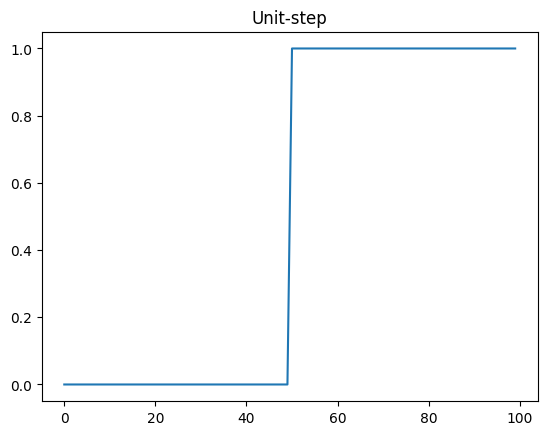

In [11]:
def sigma_perceptron(z):
    if z > 0:
        return 1
    else:
        return 0

plt.plot([sigma_perceptron(z) for z in np.linspace(-10, 10, 100)])
plt.title("Unit-step")

There is a problem with this type of decision function, which is that is not differentiable. That is why it is tricky to fit a perceptron with gradient descent.

Instead, we can use a **sigmoid function**:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

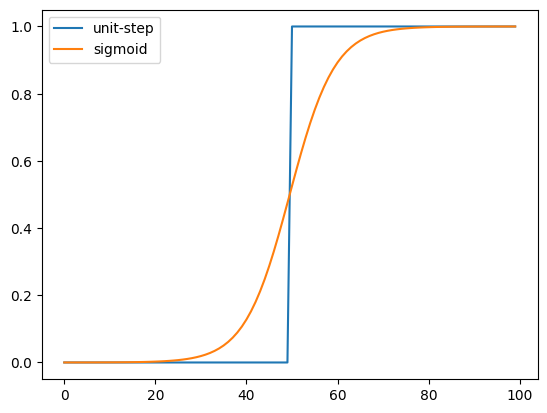

In [12]:
def sigmaoid(z):
    return 1/(1+np.exp(-z))

plt.plot([sigma_perceptron(z) for z in np.linspace(-10, 10, 100)], label="unit-step")
plt.plot([sigmaoid(z) for z in np.linspace(-10, 10, 100)], label="sigmoid")
plt.legend()
#smooth function gives a differentiable- allows us to calculate gradient descent

As you can see, this function smoothly maps any real number to the range $[0, 1]$, and can be interpreted as a **probability**.

Now, we can define ourputs as:

$$
\hat{y} = \sigma(\sum_{j=1}^m x_{ij}w_j + b) = \frac{1}{1 + e^{-\sum_{j=1}^m x_{ij}w_j - b}}$$

That is, now we have a **probabilistic binary classifier**.


### A cost function for classification

We want our predicted probabilities $\hat{y}$ to be close to the true labels $y \in \{0, 1\}$.

The most common loss function for this setting is the **Binary Cross-Entropy Cost**:

$$
J_{\text{BCE}} = - \frac{1}{N}\sum_{i=1}^N\left[y_i \log(\hat{y_i}) + (1 - y_i) \log(1 - \hat{y_i})\right]
$$

This cost:
- Is differentiable
- Penalizes confident wrong predictions
- Works well with sigmoid output

We can now train our classifier using **gradient descent**, just like in linear regression!


In [13]:
import torch
#training classifier using gradient descent just like in regression
class LogisticRegressionSGD(LinearRegressionSGD):
    def forward(self, x): #returns raw score between 0 and 1
        # Apply sigmoid to turn linear output into probability
        return torch.sigmoid(x @ self.w + self.b)

    def loss(self, y_pred, y_true):
        # Clamp to avoid log(0)- clamp predictions to very tiny number episolon (eps) and slightly below it.
        eps = torch.finfo(y_pred.dtype).eps
        y_pred = torch.clamp(y_pred, eps, 1 - eps)
#passing thru function which states whether neurone is firing or not---outputs given as probability
        return -torch.mean(y_true*torch.log(y_pred)+ (1-y_true)*torch.log(1-y_pred))

## 2. From Logistic Regression to Multi-Layer Perceptrons (MLPs)

We have just seen how logistic regression can model binary outcomes using:

$$
\hat{y} = \sigma(\mathbf{w}^\top \mathbf{x} + b)
$$

This is also known as **no-hidden layer perceptron model**.

But the problem is that this, which is a logistic regression, only maps output as a linear transformation.

But what if we have a **non-linearly separable** data?

We saw that in same cases, like SVM, we can address this problem using kernels.

But there is another way in this context which is by adding a hidden layer! This would lead to **one hidden layer perceptron** — the simplest form of a neural network.

Let's break it down here:

---

### Step 1: Add a Hidden Layer

We can capture **non-linear relationships** by adding a **hidden layer** between input and output:

$$
\hat{y} = \sigma(\sum_{k=1}^d h_{k}w^{(2)}_k + b^{(2)}), \quad \text{where} \quad h_{k} = f(\sum_{j=1}^m w_{kj}^{(1)} x_j + b_1^{(1)})
$$

This is a

It consists of:
- One **hidden layer** with an activation function $f$
- One **output layer** with sigmoid activation for binary classification

---

### Step 2: Activation Functions

If we do not apply any nonlinearity (e.g., just use identity function $f(z) = z$), then:

$$
\hat{y} = \sigma(\sum_{k=1}^d w^{(2)}_k (\sum_{j=1}^m w_{kj}^{(1)} x_j + b^{(1)}) + b^{(2)})
$$

Which can be simplified into:

$$
\hat{y} = \sigma(\sum_{k=1}^d \sum_{j=1}^m  w^{(2)}_k w_{kj}^{(1)} x_j + \sum_{k=1}^d w^{(2)}_k b^{(1)} +  b^{(2)})
$$

$$
 = \sigma(\sum_{k=1}^d \sum_{j=1}^m  w^{\text{combined}}_{kj} x_j + b^{\text{combined}})
$$


This is just **logistic regression again**!  → **Stacking linear layers without nonlinear activations does nothing.**

To break this linearity, we need a **nonlinear activation function**.

Some common activation functions are:

- **ReLU (Rectified Linear Unit)**

$$
\text{ReLU}(z) = \max(0, z)
$$

 - Most commonly used in practice
 - Helps prevent vanishing gradients
 - Fast to compute

- **Tanh**

$$
\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}
$$

- Squashes values to $[-1, 1]$
- Centered at 0 (unlike sigmoid)


- **Sigmoid**

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

- Already used in logistic regression
- Squashes values to $[0, 1]$
- Can cause vanishing gradients if used in hidden layers

---


w- connects input to hidden unit
other w - connects hidden unit to output

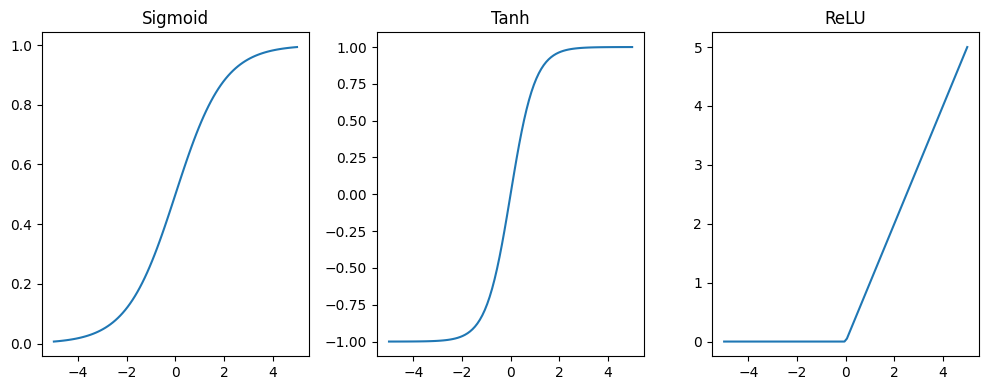

In [14]:
def relu(z):
    return  np.maximum(z, 0)

def tanh(z):
    return (np.exp(z) - np.exp(-z))/(np.exp(z) + np.exp(-z))

def sigmoid(z):
    return 1/(1+np.exp(-z))

z = np.linspace(-5, 5, 100)
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.plot(z, sigmoid(z))
plt.title('Sigmoid')

plt.subplot(1, 3, 2)
plt.plot(z, tanh(z))
plt.title('Tanh')

plt.subplot(1, 3, 3)
plt.plot(z, relu(z))
plt.title('ReLU')

plt.tight_layout()
plt.show()
#activation function tells us whther the hidden units fires or not


## Step 3: Feedforward

Once we have our simple MLP with one hidden layer, we can just generate predictions by passing input information, $\mathbf{x}$, through the architecture:

$$
\mathbf{x} \rightarrow \underbrace{\text{Linear} \rightarrow \text{ReLU}}_{\text{Hidden Layer}} \rightarrow \underbrace{\text{Linear} \rightarrow \text{Sigmoid}}_{\text{Output Layer}} \rightarrow \hat{y}
$$

- **Hidden layer**: increases expressiveness of the model  
- **Nonlinearity**: makes it possible to learn complex decision boundaries  
- **Sigmoid**: gives probability for binary classification

### Step 4: Learning

Learning is done by comparimg the model's predictions with the true targets and adjusts the weights to reduce the error.

In neural networks, this is done **backpropagation**, which computes the gradient of the cost function with respect to the weights of the network, but does so with one layer at a time, iterating backward from the last layer using the **chain rule** of calculus.

For example, for a weight $w_{ij}^{(l)}$ connecting neuron $j$ in layer $l-1$ to neuron $i$ in layer $l$, the update rule is:

$$
w_{ij}^{(l)} \leftarrow w_{ij}^{(l)} - \eta \cdot \underbrace{\delta_i^{(l)} \cdot a_j^{(l-1)}}_{\text{gradient}}
$$

where:

- $\delta_i^{(l)}$ is the error signal at neuron $i$ in layer $l$,
- $a_j^{(l-1)}$ is the activation from neuron $j$ in the previous layer,
- $\eta$ is the learning rate.

**So as you can see, this is the same learnig rule we saw previously for Linear Regression using Stochastic Gradient Descent, but the gradients now come from the previous layer.**

This update is applied to **all weights in the network**, layer by layer.

Fortunately, `PyTorch` makes our life easier by providing the `.backward()` method, which automatically computes all these gradients using the chain rule under the hood.

## 3. Implementation: A MLP model with one hidden layer in `pyTorch`

Here below are some rough steps of how to implement a MLP model in `pyTorch`. In next classes we will see how to do this in a more flexible and efficient way with  `pyTorch` as well.

**📌 Disclaimer**:  Some of the methods below, like `fit` and `predict`, are not standard in `PyTorch`. We include them for simplicity and to stay close to the familiar scikit-learn API.

### 1. Define a class for your model

This is just the name or signature. At the moment we don't have anything.

In [15]:
class MyMLPModel(object):
    pass

In [16]:
MyMLPModel

__main__.MyMLPModel

### 2. Add an `__init__` method.

This method will usually define the parameters of your model as attributes. In this case, our weights and learning rate.

In [24]:
class MyMLPModel2(object):
    def __init__(self,
                 input_dim, # Think of j index above #size of x vector
                 hidden_dim,  # Think of k index above #no. of neurones in hidden layer
                 learning_rate=0.1): #step size for weight updates
        #weight matrix connecting input layer to hidden layer
        self.W_1= torch.randn(input_dim, hidden_dim, requires_grad=True)
        #bias vector for hidden layer
        self.b_1 = torch.randn(hidden_dim, requires_grad=True)
        #----output layer parameters------
        #weight matrix connecting hidden to output layer
        self.W_2 = torch.randn(hidden_dim, 1, requires_grad=True)
        #bias for output layer
        self.b_2 = torch.randn(1, requires_grad=True)
        #------learning rate-----
        #learning rate controls how much to adjust weights during trainig
        self.learning_rate = learning_rate
        # COMES HERE (Create W_1, b_1, W_2, b_2, and learning rate; requires_grad = True)

### 3. Add a `forward` method.

This will define how to calculate an output provided an input. In other words, it's like trasversing the neural network.

Here we will also need to define our activation functions for the different layers.

In [25]:
def sigmoid(z):
    #sigmoid activation: squashes values into range(0,1)
    #used in output layer for binary classification
    return 1/(1+torch.exp(-z))

def relu(z):
    #this activation sets all negative values to 0
    #used in hidden layer to add nonlinearity
    return torch.maximum(z, torch.tensor(0.0))

class MyMLPModel3(MyMLPModel2):

    def forward(self, X):
        # 1-input to hidden units
        #computes weighted sum of inputs + bias for hidden neurones: h= X*W_1 + b_1
        h = torch.matmul(X, self.W_1) + self.b_1 # COMES HERE (matmul X and W_1 + b_1)

        # 2-Find output in each units through their activation function (ReLU in this case)
        #apply activation- model learns complex patterns
        h_relu = relu(h)

        # 3- These outputs server as input to the last, output layer consisting of just one unit.
        #compute your final output:out = h_relu * W_2 + b_2
        out = torch.matmul(h_relu, self.W_2) + self.b_2 # COMES HERE (matmul h_relu and W_1 + b_1)
        return sigmoid(out)

        #Step 1: Multiply input X with first weight matrix (W_1) → add bias → get hidden layer input.
        #Step 2: Apply ReLU so the model can learn nonlinear relationships.
        #Step 3: Multiply that hidden layer output with W_2 → add bias → get final score.
        #Step 4: Apply Sigmoid to turn that score into a probability between 0 and 1.

### 4. Add a method `fit` to handle all the training

In [26]:
# ---------------- Binary Cross-Entropy Loss ----------------
def log_cost(y_pred, y_true):
    # Clamp values to avoid log(0) errors (numerical stability)
    eps = torch.finfo(y_pred.dtype).eps
    y_pred = torch.clamp(y_pred, eps, 1 - eps)

    # Compute Binary Cross-Entropy Loss:
    # L = -mean(y_true*log(y_pred) + (1 - y_true)*log(1 - y_pred))
    return -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))


# ---------------- Multi-Layer Perceptron Class ----------------
class MyMLPModel(object):

    def __init__(self,
                 input_dim,     # Number of input features
                 hidden_dim,    # Number of neurons in hidden layer
                 learning_rate=0.1):  # Step size for parameter updates

        # Hidden layer weights and bias
        self.W_1 = torch.randn(input_dim, hidden_dim, requires_grad=True)
        self.b_1 = torch.randn(hidden_dim, requires_grad=True)

        # Output layer weights and bias
        self.W_2 = torch.randn(hidden_dim, 1, requires_grad=True)
        self.b_2 = torch.randn(1, requires_grad=True)

        # Learning rate
        self.learning_rate = learning_rate


    # ---------------- Forward Pass ----------------
    def forward(self, X):
        # 1️⃣ Input → Hidden Linear Combination
        h = torch.matmul(X, self.W_1) + self.b_1

        # 2️⃣ Apply ReLU Activation
        h_relu = relu(h)

        # 3️⃣ Hidden → Output Linear Combination
        out = torch.matmul(h_relu, self.W_2) + self.b_2

        # 4️⃣ Apply Sigmoid to get probabilities between 0 and 1
        return sigmoid(out)


    # ---------------- Training with SGD ----------------
    def fit(self, X, y, n_epochs=100):

        for epoch in range(n_epochs):

            # Shuffle data indices for stochastic gradient descent
            randperm = torch.randperm(X.shape[0])

            # Loop through one sample at a time
            for ii in randperm:
                x_batch, y_batch = X[ii], y[ii]  # pick one training example

                # ---------- Forward Pass ----------
                probs = self.forward(x_batch)     # COMES HERE (forward on x_batch)

                # ---------- Compute Loss ----------
                cost = log_cost(probs, y_batch)   # COMES HERE (log_cost probs and y_batch)

                # ---------- Backward Pass ----------
                cost.backward()  # compute gradients via autograd

                # ---------- Gradient Descent Update ----------
                with torch.no_grad():
                    # Update first layer parameters
                    self.W_1 -= self.learning_rate * self.W_1.grad
                    self.b_1 -= self.learning_rate * self.b_1.grad

                    # Update second layer parameters
                    self.W_2 -= self.learning_rate * self.W_2.grad
                    self.b_2 -= self.learning_rate * self.b_2.grad

                    # ---------- Zero Gradients ----------
                    # Reset gradients for next iteration
                    self.W_1.grad.zero_()
                    self.b_1.grad.zero_()
                    self.W_2.grad.zero_()
                    self.b_2.grad.zero_()
                    # COMES HERE (Set gradient weights to zero, call zero_())

            # ---------- Print Progress ----------
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Cost: {cost.item():.4f}")

        return self


### 5. Final model: Add a `predict` function

This is just to stick to the `scikit-learn` API

In [27]:
class MyMLPModel(object):

    def __init__(self,
                 input_dim,
                 hidden_dim,
                 learning_rate=0.1):

        self.W_1 = torch.randn(input_dim, hidden_dim, requires_grad=True)
        self.b_1 = torch.randn(hidden_dim, requires_grad=True)
        self.W_2 = torch.randn(hidden_dim, 1, requires_grad=True)
        self.b_2 = torch.randn(1, requires_grad=True)
        self.learning_rate = learning_rate

    def forward(self, X):
        # 1-input to hidden units
        h = torch.matmul(X, self.W_1) + self.b_1
        # 2-Find output in each units through their activation function (ReLU in this case)
        h_relu = relu(h)
        # 3- These outputs server as input to the last, output layer consisting of just one unit.
        out = torch.matmul(h_relu, self.W_2) + self.b_2
        return sigmoid(out)

    def fit(self, X, y, n_epochs=100):

        for epoch in range(n_epochs):

            randperm = torch.randperm(X.shape[0])
            for ii in randperm:
                x_batch, y_batch = X[ii], y[ii]

                # Forward pass
                probs = self.forward(x_batch)

                # the cost function
                cost = log_cost(probs, y_batch)

                # Backward pass
                cost.backward()

                # Gradient descent step (manual)
                with torch.no_grad():
                    self.W_1 -= self.learning_rate * self.W_1.grad
                    self.b_1 -= self.learning_rate * self.b_1.grad
                    self.W_2 -= self.learning_rate * self.W_2.grad
                    self.b_2 -= self.learning_rate * self.b_2.grad

                    # Zero gradients
                    self.W_1.grad.zero_()
                    self.b_1.grad.zero_()
                    self.W_2.grad.zero_()
                    self.b_2.grad.zero_()

            # Print cost every 10 epochs
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Cost: {cost.item():.4f}")
        return self

    def predict(self, X):
        with torch.no_grad(): #prevents gradient computation, speeds up inference, saves memory

            # Calculate probabilites of input data
            probs = self.forward(X) #computes the network's output probabilities
            # Assign label
            predicted = (probs > 0.5).float() #if prob > 0.5, assigns prediction to +ve class and below 0.5 then assigned to -ve class
            #converts probability into discrete class predictions
        return predicted #returns a tensor.

---

Let's put this into practice!

In [28]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

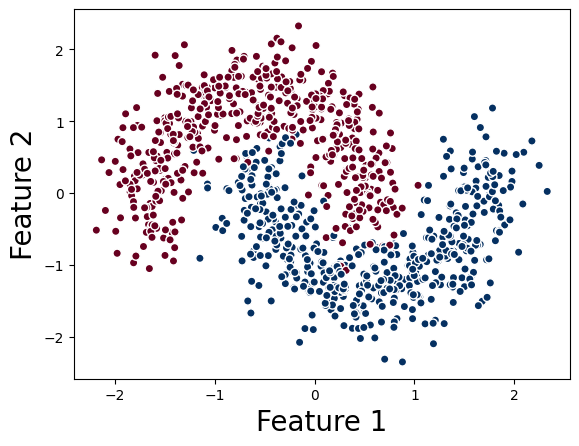

In [29]:
plt.scatter(X[:,0], X[:,1], c=y, cmap="RdBu", edgecolors='w', alpha=1)
plt.xlabel("Feature 1", size=20)
plt.ylabel("Feature 2", size=20)
plt.show()
#non linear class seperations - 2 sinusoidal distribution functions- need a non linear classifier to seperate the classes

Let's use our implementation *a la* `scikit-learn`

In [32]:
torch.manual_seed(1234)

# 1-Instantiate the model
mlp_model = MyMLPModel(input_dim=X.shape[1], hidden_dim=10, learning_rate=0.01)
mlp_model.W_1, mlp_model.W_2
# 2-Fit (on the training)
mlp_model.fit(X_train, y_train, n_epochs=50)
# 3-Predict
y_pred = mlp_model.predict(X_test).numpy().flatten()


# 4-Assess generalizability

print("the performance of this model after 50 epochs of training is", accuracy_score(y_test, y_pred))

Epoch 0, Cost: 2.3883
Epoch 10, Cost: 0.0042
Epoch 20, Cost: 0.0917
Epoch 30, Cost: 0.0008
Epoch 40, Cost: 0.0092
the performance of this model after 50 epochs of training is 0.98


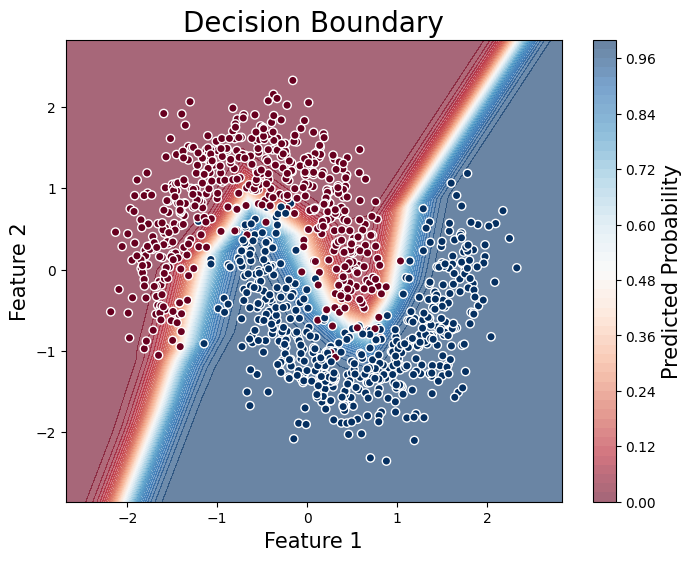

In [33]:
# Create a grid of points covering the feature space
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 1000),
    np.linspace(y_min, y_max, 1000)
)
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# Get model predictions on the grid
with torch.no_grad():
    probs = mlp_model.forward(grid_tensor).numpy().reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probs, levels=50, cmap="RdBu", alpha=0.6)
cbar = plt.colorbar()
cbar.set_label("Predicted Probability", size=15)
cbar.ax.tick_params(labelsize=10)
# Overlay training data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="RdBu", edgecolors='w', alpha=1)
plt.title("Decision Boundary", size=20)
plt.xlabel("Feature 1", size=15)
plt.ylabel("Feature 2", size=15)
plt.show()


### Simplifying things: `torch.nn.functional`

Ok, so we have been able to implement our simple neural network, but for that we needed to have several functions like the activations and the cost functions implemented by ourselves.

But wait... do we really need to implement all these functions ourselves every time?

Of course not! Most machine learning and deep learning libraries already provide these commonly used components for you — either as functions or modular layers.

In `PyTorch`, many of these are available in the `torch.nn.functional` module, which is generally imported into the namespace `F` by convention.  Let us have a look!

In [34]:
import torch.nn.functional as F

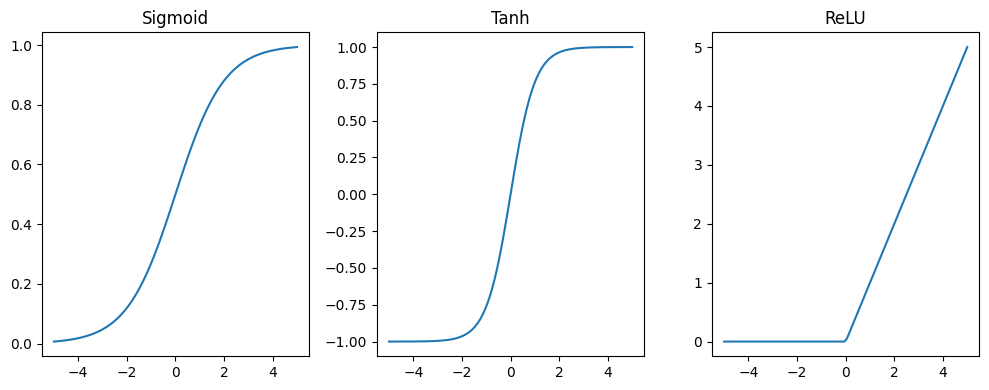

In [35]:
z = np.linspace(-5, 5, 100)
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.plot(z, F.sigmoid(torch.Tensor(z)))
plt.title('Sigmoid')

plt.subplot(1, 3, 2)
plt.plot(z, F.tanh(torch.Tensor(z)))
plt.title('Tanh')

plt.subplot(1, 3, 3)
plt.plot(z, F.relu(torch.Tensor(z)))
plt.title('ReLU')

plt.tight_layout()
plt.show()

## 4. The Universal Approximation Theorem (Optional)

There is a deeper, more theoretical reason why neural networks are so important in machine learning. It comes down to the **Universal Approximation Theorem**, which states:

> A feedforward neural network with **a single hidden layer** containing a **finite number of neurons** can approximate **any continuous function** on a compact domain to **arbitrary precision**, provided it uses a **nonlinear activation function** (like sigmoid or tanh).

### Key Takeaways:

- Even shallow networks (just one hidden layer) are **theoretically powerful**.
- In practice, **depth** (more layers) helps with efficiency, generalization, and learning hierarchical features.
- The theorem provides a **theoretical guarantee**, but not a **training guarantee** — it does not ensure that gradient descent will find the optimal solution.

### Why Is This Important?

This theorem gives us **confidence** that neural networks are expressive enough to model very complex phenomena — including patterns in images, text, sound, and brain data.

But it also reminds us that:
- **Architecture design matters**
- **Training matters**
- **Optimization is not trivial**


## 5. Summary

- A **neural network** is a function approximator composed of layers of interconnected "neurons." Each neuron performs:
    - A **linear transformation** of the inputs (dot product + bias)
    - Followed by a **nonlinear activation function** (e.g., ReLU, Tanh)
    - Basic structure of a **feedforward neural network** (also called Multi-Layer Perceptron, or MLP):

    $$
    \mathbf{x} \rightarrow \text{Linear} \rightarrow \text{Activation} \rightarrow \text{Linear} \rightarrow \text{Activation} \rightarrow \dots \rightarrow \hat{y}
    $$

    - Learning is done through **backpropagation**
  

## 6. 📝 Exercises

### 6.1 Compare with other models:
- Use `scikit-learn` to train a **Logistic Regression** and a **Support Vector Machine (SVM)** on the same toy data of this class.
- Plot the decision boundaries.
- Compare the performances compare between the three models. Did the MLP outperforms these other models?

In [ ]:
# YOUR CODE

### 6.2 Replicate MLP with `scikit-learn`

In this class we used `Pytorch` to implement and use a multi-layer perceptron. HHowever, `scikit-learn` also provides a built-in implementation through `MLPClassifier`  (and `MLPRegressor` for regression tasks, by the way).

In this exercise, you will replicate our example using `MLPClassifier` with a similar architecture.

- Read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html), and explain which parameters should be set to match our `PyTorch` implementation as closely as possible.
- Train the model and generate predictions.
- Compute the accuracy and decision boundary.
- **Reflect**: What do you think are the tradeoffs between using `PyTorch` and `scikit-learn` for neural networks? Consider flexibility, ease of use, and transparency.

In [ ]:
# YOUR CODE